In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# 데이터 불러오기

In [2]:
building= pd.read_csv('../power/building_info.csv')
df= pd.read_csv('../power/train.csv')

# 데이터셋 EDA

In [3]:
building.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [5]:
df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [6]:
df['건물번호'].unique() 

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [7]:
# 건물 총 100채

# na값 찾기

In [8]:
# na값 찾기
df[df['기온(C)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)


In [9]:
df[~df['강수량(mm)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
104,1_20220605 08,1,20220605 08,22.9,0.0,1.3,55.0,0.0,0.25,1440.48
105,1_20220605 09,1,20220605 09,23.6,0.0,1.2,53.0,0.0,0.51,1814.40
116,1_20220605 20,1,20220605 20,20.9,0.0,3.2,64.0,0.0,0.02,2054.40
117,1_20220605 21,1,20220605 21,20.5,0.0,2.4,70.0,NaN,NaN,1716.00
123,1_20220606 03,1,20220606 03,19.3,1.3,1.5,84.0,NaN,NaN,964.32
...,...,...,...,...,...,...,...,...,...,...
203966,100_20220823 14,100,20220823 14,23.8,0.4,0.5,99.0,0.0,NaN,1137.36
203967,100_20220823 15,100,20220823 15,23.8,1.0,0.9,99.0,0.0,NaN,1126.08
203968,100_20220823 16,100,20220823 16,24.4,0.2,0.9,98.0,0.0,NaN,1165.20
203987,100_20220824 11,100,20220824 11,23.7,0.0,0.9,87.0,0.0,NaN,1056.48


In [10]:
# 강수량값이 실제로 존재함. na값-> 0.0으로 채워넣기
df['강수량(mm)'] = df['강수량(mm)'].fillna(0.0)

In [11]:
# na 있는지 다시 확인 -> 없음
df[df['강수량(mm)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)


# 풍속 전처리 : 평균값으로...

In [12]:
df[df['풍속(m/s)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
16643,9_20220614 11,9,20220614 11,17.6,0.0,NaN,NaN,NaN,NaN,2330.40
30161,15_20220806 17,15,20220806 17,35.6,0.0,NaN,NaN,NaN,NaN,1815.57
32127,16_20220803 15,16,20220803 15,30.4,0.0,NaN,77.0,0.5,2.06,5062.08
51640,26_20220627 16,26,20220627 16,27.2,3.1,NaN,93.0,0.0,0.27,5330.40
51921,26_20220709 09,26,20220709 09,26.3,0.0,NaN,84.0,0.0,0.81,2908.80
84418,42_20220703 10,42,20220703 10,29.8,0.0,NaN,66.0,1.0,2.61,3038.76
100738,50_20220703 10,50,20220703 10,29.8,0.0,NaN,66.0,1.0,2.61,3044.70
105639,52_20220806 15,52,20220806 15,33.4,0.0,NaN,72.0,0.0,NaN,2260.20
105640,52_20220806 16,52,20220806 16,33.5,0.0,NaN,73.0,0.0,NaN,2274.30
176477,87_20220714 05,87,20220714 05,21.9,0.0,NaN,NaN,NaN,NaN,519.66


In [13]:
df[df['num_date_time']=='15_20220806 16'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
30160,15_20220806 16,15,20220806 16,35.7,0.0,2.7,54.0,1.0,1.9,1774.08


In [14]:
df[df['num_date_time']=='15_20220806 18']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
30162,15_20220806 18,15,20220806 18,35.6,0.0,2.4,56.0,NaN,NaN,1868.76


In [15]:
df.loc[df["num_date_time"] == "15_20220806 17", "풍속(m/s)"] = (2.7 + 2.4) / 2

In [16]:
df[df['num_date_time']=='26_20220627 15'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
51639,26_20220627 15,26,20220627 15,28.5,0.0,1.0,82.0,0.0,0.58,5522.4


In [17]:
df[df['num_date_time']=='26_20220627 17'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
51641,26_20220627 17,26,20220627 17,26.7,1.1,0.5,92.0,0.0,0.21,4989.12


In [18]:
df.loc[df["num_date_time"] == "26_20220627 16", "풍속(m/s)"] = (1.0 + 0.75) / 2

In [19]:
df[df['num_date_time']=='97_20220806 14']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
197438,97_20220806 14,97,20220806 14,33.2,0.0,5.0,74.0,1.0,3.09,1978.74


In [20]:
df[df['num_date_time']=='97_20220806 15']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
197439,97_20220806 15,97,20220806 15,33.4,0.0,NaN,72.0,0.0,NaN,2021.04


In [21]:
df[df['num_date_time']=='97_20220806 16']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
197440,97_20220806 16,97,20220806 16,33.5,0.0,NaN,73.0,0.0,NaN,1994.58


In [22]:
df[df['num_date_time']=='97_20220806 17']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
197441,97_20220806 17,97,20220806 17,32.4,0.0,3.0,77.0,0.5,1.44,1944.18


In [23]:
df.loc[df["num_date_time"] == "97_20220806 15", "풍속(m/s)"] = (5.0 + 3.0) / 2
df.loc[df["num_date_time"] == "97_20220806 16", "풍속(m/s)"] = (5.0 + 3.0) / 2

In [24]:
df[df['num_date_time']=='9_20220614 10'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
16642,9_20220614 10,9,20220614 10,17.5,0.6,3.8,94.0,0.0,0.38,2253.12


In [25]:
df[df['num_date_time']=='9_20220614 12'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
16644,9_20220614 12,9,20220614 12,17.7,0.0,4.6,91.0,NaN,NaN,2299.68


In [26]:
df.loc[df["num_date_time"] == "9_20220614 11", "풍속(m/s)"] = (3.8 + 4.6) / 2

In [27]:
df[df['num_date_time']=='16_20220803 14'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
32126,16_20220803 14,16,20220803 14,30.2,0.0,3.9,78.0,0.3,2.17,4992.48


In [28]:
df[df['num_date_time']=='16_20220803 16'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
32128,16_20220803 16,16,20220803 16,29.4,0.0,3.8,80.0,0.5,1.73,5145.12


In [29]:
df.loc[df["num_date_time"] == "16_20220803 15", "풍속(m/s)"] = (3.9 + 3.8) / 2

In [30]:
df[df['num_date_time']=='26_20220627 15'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
51639,26_20220627 15,26,20220627 15,28.5,0.0,1.0,82.0,0.0,0.58,5522.4


In [31]:
df[df['num_date_time']=='26_20220627 17'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
51641,26_20220627 17,26,20220627 17,26.7,1.1,0.5,92.0,0.0,0.21,4989.12


In [32]:
df.loc[df["num_date_time"] == "26_20220627 17", "풍속(m/s)"] = (1.0 + 0.5) / 2

In [33]:
df[df['num_date_time']=='26_20220709 08'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
51920,26_20220709 08,26,20220709 08,25.4,0.0,0.0,91.0,0.0,0.42,2845.92


In [34]:
df[df['num_date_time']=='26_20220709 10'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
51922,26_20220709 10,26,20220709 10,27.1,0.0,1.0,82.0,0.2,1.33,3143.52


In [35]:
df.loc[df["num_date_time"] == "26_20220709 09", "풍속(m/s)"] = (0.0 + 1.0) / 2

In [36]:
df[df['num_date_time']=='42_20220703 09'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
84417,42_20220703 09,42,20220703 09,29.5,0.0,0.9,61.0,0.8,1.83,1832.4


In [37]:
df[df['num_date_time']=='42_20220703 11'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
84419,42_20220703 11,42,20220703 11,30.5,0.0,1.7,63.0,0.9,2.46,3155.04


In [38]:
df.loc[df["num_date_time"] == "42_20220703 10", "풍속(m/s)"] = (0.9 + 1.7) / 2

In [39]:
df[df['num_date_time']=='50_20220703 09'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
100737,50_20220703 09,50,20220703 09,29.5,0.0,0.9,61.0,0.8,1.83,2962.2


In [40]:
df[df['num_date_time']=='50_20220703 11'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
100739,50_20220703 11,50,20220703 11,30.5,0.0,1.7,63.0,0.9,2.46,3022.2


In [41]:
df.loc[df["num_date_time"] == "50_20220703 10", "풍속(m/s)"] = (0.9 + 1.7) / 2

In [42]:
df[df['num_date_time']=='52_20220806 14'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
105638,52_20220806 14,52,20220806 14,33.2,0.0,5.0,74.0,1.0,3.09,2202.9


In [43]:
df[df['num_date_time']=='52_20220806 15'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
105639,52_20220806 15,52,20220806 15,33.4,0.0,NaN,72.0,0.0,NaN,2260.2


In [44]:
df[df['num_date_time']=='52_20220806 16'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
105640,52_20220806 16,52,20220806 16,33.5,0.0,NaN,73.0,0.0,NaN,2274.3


In [45]:
df[df['num_date_time']=='52_20220806 17'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
105641,52_20220806 17,52,20220806 17,32.4,0.0,3.0,77.0,0.5,1.44,2185.8


In [46]:
df.loc[df["num_date_time"] == "52_20220806 15", "풍속(m/s)"] = (5.0 + 3.0) / 2
df.loc[df["num_date_time"] == "52_20220806 16", "풍속(m/s)"] = (5.0 + 3.0) / 2

In [47]:
df[df['num_date_time']=='87_20220714 04'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176476,87_20220714 04,87,20220714 04,21.5,0.5,1.4,100.0,NaN,NaN,438.48


In [48]:
df[df['num_date_time']=='87_20220714 05'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176477,87_20220714 05,87,20220714 05,21.9,0.0,NaN,NaN,NaN,NaN,519.66


In [49]:
df[df['num_date_time']=='87_20220714 06'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176478,87_20220714 06,87,20220714 06,22.3,0.0,NaN,NaN,NaN,NaN,632.88


In [50]:
df[df['num_date_time']=='87_20220714 07'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176479,87_20220714 07,87,20220714 07,22.8,0.0,NaN,NaN,NaN,NaN,738.72


In [51]:
df[df['num_date_time']=='87_20220714 08'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176480,87_20220714 08,87,20220714 08,23.3,0.0,NaN,NaN,NaN,NaN,1547.28


In [52]:
df[df['num_date_time']=='87_20220714 09'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176481,87_20220714 09,87,20220714 09,23.8,0.0,NaN,NaN,NaN,NaN,2059.74


In [53]:
df[df['num_date_time']=='87_20220714 10'] 

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176482,87_20220714 10,87,20220714 10,24.2,0.0,1.3,90.0,0.0,0.73,1966.5


In [54]:
df.loc[df["num_date_time"] == "87_20220714 05", "풍속(m/s)"] = (1.4 + 1.3) / 2
df.loc[df["num_date_time"] == "87_20220714 06", "풍속(m/s)"] = (1.4 + 1.3) / 2
df.loc[df["num_date_time"] == "87_20220714 07", "풍속(m/s)"] = (1.4 + 1.3) / 2
df.loc[df["num_date_time"] == "87_20220714 08", "풍속(m/s)"] = (1.4 + 1.3) / 2
df.loc[df["num_date_time"] == "87_20220714 09", "풍속(m/s)"] = (1.4 + 1.3) / 2

In [55]:
df[df['num_date_time']=='90_20220806 16']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
183160,90_20220806 16,90,20220806 16,35.7,0.0,2.7,54.0,1.0,1.9,2551.92


In [56]:
df[df['num_date_time']=='90_20220806 18']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
183162,90_20220806 18,90,20220806 18,35.6,0.0,2.4,56.0,NaN,NaN,2428.08


In [57]:
df.loc[df["num_date_time"] == "90_20220806 17", "풍속(m/s)"] = (1.3 + 2.7) / 2

In [58]:
df[df['num_date_time']=='97_20220806 14']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
197438,97_20220806 14,97,20220806 14,33.2,0.0,5.0,74.0,1.0,3.09,1978.74


In [59]:
df[df['num_date_time']=='97_20220806 15']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
197439,97_20220806 15,97,20220806 15,33.4,0.0,4.0,72.0,0.0,NaN,2021.04


In [60]:
df[df['num_date_time']=='97_20220806 16']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
197440,97_20220806 16,97,20220806 16,33.5,0.0,4.0,73.0,0.0,NaN,1994.58


In [61]:
df[df['num_date_time']=='97_20220806 17']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
197441,97_20220806 17,97,20220806 17,32.4,0.0,3.0,77.0,0.5,1.44,1944.18


In [62]:
df.loc[df["num_date_time"] == "90_20220806 15", "풍속(m/s)"] = (5.0 + 3.0) / 2
df.loc[df["num_date_time"] == "90_20220806 16", "풍속(m/s)"] = (5.0 + 3.0) / 2

In [63]:
df[df['num_date_time']=='100_20220608 14']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
202142,100_20220608 14,100,20220608 14,24.7,0.0,1.9,52.0,NaN,NaN,880.56


In [64]:
df[df['num_date_time']=='100_20220608 16']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
202144,100_20220608 16,100,20220608 16,25.0,0.0,1.6,53.0,NaN,NaN,872.4


In [65]:
df.loc[df["num_date_time"] == "100_20220608 15", "풍속(m/s)"] = (1.9 + 1.6) / 2

In [66]:
df[df['num_date_time']=='100_20220723 02']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
203210,100_20220723 02,100,20220723 02,20.5,0.0,0.0,99.0,NaN,NaN,353.28


In [67]:
df[df['num_date_time']=='100_20220723 04']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
203212,100_20220723 04,100,20220723 04,20.5,0.0,0.0,100.0,NaN,NaN,333.36


In [68]:
df.loc[df["num_date_time"] == "100_20220723 03", "풍속(m/s)"] = (0.0 + 0.0) / 2

In [69]:
df[df['풍속(m/s)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)


# 습도 전처리 : 평균값으로

In [70]:
df[df['습도(%)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
16643,9_20220614 11,9,20220614 11,17.6,0.0,4.20,NaN,NaN,NaN,2330.40
30161,15_20220806 17,15,20220806 17,35.6,0.0,2.55,NaN,NaN,NaN,1815.57
176477,87_20220714 05,87,20220714 05,21.9,0.0,1.35,NaN,NaN,NaN,519.66
176478,87_20220714 06,87,20220714 06,22.3,0.0,1.35,NaN,NaN,NaN,632.88
176479,87_20220714 07,87,20220714 07,22.8,0.0,1.35,NaN,NaN,NaN,738.72
176480,87_20220714 08,87,20220714 08,23.3,0.0,1.35,NaN,NaN,NaN,1547.28
176481,87_20220714 09,87,20220714 09,23.8,0.0,1.35,NaN,NaN,NaN,2059.74
183161,90_20220806 17,90,20220806 17,35.6,0.0,2.00,NaN,NaN,NaN,2504.16
202143,100_20220608 15,100,20220608 15,24.9,0.0,1.75,NaN,NaN,NaN,880.32


In [71]:
df[df['num_date_time']=='9_20220614 10']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
16642,9_20220614 10,9,20220614 10,17.5,0.6,3.8,94.0,0.0,0.38,2253.12


In [72]:
df[df['num_date_time']=='9_20220614 12']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
16644,9_20220614 12,9,20220614 12,17.7,0.0,4.6,91.0,NaN,NaN,2299.68


In [73]:
df.loc[df["num_date_time"] == "9_20220614 11", "습도(%)"] = (94.0 + 91.0) / 2

In [74]:
df[df['num_date_time']=='15_20220806 16']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
30160,15_20220806 16,15,20220806 16,35.7,0.0,2.7,54.0,1.0,1.9,1774.08


In [75]:
df[df['num_date_time']=='9_20220614 18']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
16650,9_20220614 18,9,20220614 18,17.0,0.0,3.0,92.0,0.0,0.14,2318.4


In [76]:
df.loc[df["num_date_time"] == "9_20220614 11", "습도(%)"] = (54.0 + 92.0) / 2

In [77]:
df[df['num_date_time']=='87_20220714 04']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176476,87_20220714 04,87,20220714 04,21.5,0.5,1.4,100.0,NaN,NaN,438.48


In [78]:
df[df['num_date_time']=='87_20220714 05']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176477,87_20220714 05,87,20220714 05,21.9,0.0,1.35,NaN,NaN,NaN,519.66


In [79]:
df[df['num_date_time']=='87_20220714 06']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176478,87_20220714 06,87,20220714 06,22.3,0.0,1.35,NaN,NaN,NaN,632.88


In [80]:
df[df['num_date_time']=='87_20220714 07']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176479,87_20220714 07,87,20220714 07,22.8,0.0,1.35,NaN,NaN,NaN,738.72


In [81]:
df[df['num_date_time']=='87_20220714 08']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176480,87_20220714 08,87,20220714 08,23.3,0.0,1.35,NaN,NaN,NaN,1547.28


In [82]:
df[df['num_date_time']=='87_20220714 09']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176481,87_20220714 09,87,20220714 09,23.8,0.0,1.35,NaN,NaN,NaN,2059.74


In [83]:
df[df['num_date_time']=='87_20220714 10']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
176482,87_20220714 10,87,20220714 10,24.2,0.0,1.3,90.0,0.0,0.73,1966.5


In [84]:
df.loc[df["num_date_time"] == "87_20220714 05", "습도(%)"] = (100.0 + 90.0) / 2
df.loc[df["num_date_time"] == "87_20220714 06", "습도(%)"] = (100.0 + 90.0) / 2
df.loc[df["num_date_time"] == "87_20220714 07", "습도(%)"] = (100.0 + 90.0) / 2
df.loc[df["num_date_time"] == "87_20220714 08", "습도(%)"] = (100.0 + 90.0) / 2
df.loc[df["num_date_time"] == "87_20220714 09", "습도(%)"] = (100.0 + 90.0) / 2

In [85]:
df[df['num_date_time']=='90_20220806 16']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
183160,90_20220806 16,90,20220806 16,35.7,0.0,4.0,54.0,1.0,1.9,2551.92


In [86]:
df[df['num_date_time']=='90_20220806 18']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
183162,90_20220806 18,90,20220806 18,35.6,0.0,2.4,56.0,NaN,NaN,2428.08


In [87]:
df.loc[df["num_date_time"] == "90_20220806 17", "습도(%)"] = (54.0 + 56.0) / 2

In [88]:
df[df['num_date_time']=='100_20220608 14']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
202142,100_20220608 14,100,20220608 14,24.7,0.0,1.9,52.0,NaN,NaN,880.56


In [89]:
df[df['num_date_time']=='100_20220608 16']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
202144,100_20220608 16,100,20220608 16,25.0,0.0,1.6,53.0,NaN,NaN,872.4


In [90]:
df.loc[df["num_date_time"] == "100_20220608 15", "습도(%)"] = (52.0 + 53.0) / 2

In [91]:
df[df['num_date_time']=='15_20220806 16']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
30160,15_20220806 16,15,20220806 16,35.7,0.0,2.7,54.0,1.0,1.9,1774.08


In [92]:
df[df['num_date_time']=='15_20220806 18']

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
30162,15_20220806 18,15,20220806 18,35.6,0.0,2.4,56.0,NaN,NaN,1868.76


In [93]:
df.loc[df["num_date_time"] == "15_20220806 17", "습도(%)"] = (54.0 + 56.0) / 2

In [94]:
df[df['습도(%)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)


# 일조량 전처리

In [95]:
df[df['일조(hr)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203980,100_20220824 04,100,20220824 04,21.5,0.0,1.8,92.0,NaN,NaN,379.20
203981,100_20220824 05,100,20220824 05,21.7,0.0,2.4,91.0,NaN,NaN,418.32
203997,100_20220824 21,100,20220824 21,21.3,0.0,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,0.0,0.3,94.0,NaN,NaN,640.08


In [96]:
df.describe()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
count,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,128818.000000,116087.000000,204000.000000
mean,50.500000,25.543524,0.439489,2.134050,78.716305,0.333637,1.063823,2451.036462
std,28.866141,3.779523,2.539497,1.358119,15.080290,0.401486,1.001030,2440.648858
min,1.000000,10.100000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000
25%,25.750000,23.400000,0.000000,1.200000,69.000000,0.000000,0.200000,1085.760000
50%,50.500000,25.700000,0.000000,2.000000,81.000000,0.100000,0.710000,1766.400000
75%,75.250000,28.100000,0.000000,2.800000,91.000000,0.700000,1.780000,2970.000000
max,100.000000,37.100000,92.200000,13.300000,100.000000,1.000000,3.920000,25488.400000


In [97]:
# 일조의 경우 128,818개 non-na 고, 75182개가 na값 -> 전체 평균값으로 해서 일괄 적용
204000-75182

128818

In [98]:
df['일조(hr)'].fillna(round(df['일조(hr)'].mean(),2), inplace=True)

In [99]:
df[df['일조(hr)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)


# 일사량 전처리

In [100]:
df[df['일사(MJ/m2)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,0.33,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,0.33,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,0.33,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,0.33,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,0.33,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,0.0,0.9,86.0,0.50,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,0.0,1.3,86.0,0.00,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,0.0,1.0,92.0,0.33,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,0.0,0.3,94.0,0.33,NaN,640.08


In [101]:
# 일사량의 경우 204000 중 116087개가 non-na, 116087개가 na -> 평균값으로 대체
204000-87913

116087

In [102]:
df['일사(MJ/m2)'].fillna(round(df['일사(MJ/m2)'].mean(),2), inplace=True)

In [103]:
df[df['일사(MJ/m2)'].isna()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)


In [104]:
# 결측치 확인
df.isna().sum()

num_date_time    0
건물번호             0
일시               0
기온(C)            0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
일조(hr)           0
일사(MJ/m2)        0
전력소비량(kWh)       0
dtype: int64

In [105]:
df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,0.33,1.06,1085.28
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,0.33,1.06,1047.36
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,0.33,1.06,974.88
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,0.33,1.06,953.76
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,0.33,1.06,986.40


In [106]:
df.to_csv('../power/train_df.csv', index=False)

In [107]:
df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,0.33,1.06,1085.28
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,0.33,1.06,1047.36
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,0.33,1.06,974.88
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,0.33,1.06,953.76
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,0.33,1.06,986.40


In [108]:
# num_date_time과 건물번호, 일시 겹침
# num_date_time 삭제 및 일시를 일자와 시간으로 나누어서 관리 & 일시도 삭제

In [109]:
df = df.drop(['num_date_time'], axis=1)

In [110]:
df['연도'] = df['일시'].apply(lambda x : int(x[:4]))
df['월'] = df['일시'].apply(lambda x : int(x[4:6]))
df['일'] = df['일시'].apply(lambda x : int(x[6:8]))
df['시간'] = df['일시'].apply(lambda x : int(x[9:11]))

In [111]:
df.head()

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),연도,월,일,시간
0,1,20220601 00,18.6,0.0,0.9,42.0,0.33,1.06,1085.28,2022,6,1,0
1,1,20220601 01,18.0,0.0,1.1,45.0,0.33,1.06,1047.36,2022,6,1,1
2,1,20220601 02,17.7,0.0,1.5,45.0,0.33,1.06,974.88,2022,6,1,2
3,1,20220601 03,16.7,0.0,1.4,48.0,0.33,1.06,953.76,2022,6,1,3
4,1,20220601 04,18.4,0.0,2.8,43.0,0.33,1.06,986.40,2022,6,1,4


In [112]:
df = df.drop(['일시'], axis=1)

In [113]:
df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),연도,월,일,시간
0,1,18.6,0.0,0.9,42.0,0.33,1.06,1085.28,2022,6,1,0
1,1,18.0,0.0,1.1,45.0,0.33,1.06,1047.36,2022,6,1,1
2,1,17.7,0.0,1.5,45.0,0.33,1.06,974.88,2022,6,1,2
3,1,16.7,0.0,1.4,48.0,0.33,1.06,953.76,2022,6,1,3
4,1,18.4,0.0,2.8,43.0,0.33,1.06,986.40,2022,6,1,4


In [114]:
# 피처 정리

In [115]:
df = df[["연도", "월","일", "시간", "건물번호", "기온(C)", "강수량(mm)", "풍속(m/s)", "습도(%)", "일조(hr)", "일사(MJ/m2)", "전력소비량(kWh)"]]
df.head()

,연도,월,일,시간,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,2022,6,1,0,1,18.6,0.0,0.9,42.0,0.33,1.06,1085.28
1,2022,6,1,1,1,18.0,0.0,1.1,45.0,0.33,1.06,1047.36
2,2022,6,1,2,1,17.7,0.0,1.5,45.0,0.33,1.06,974.88
3,2022,6,1,3,1,16.7,0.0,1.4,48.0,0.33,1.06,953.76
4,2022,6,1,4,1,18.4,0.0,2.8,43.0,0.33,1.06,986.40


In [116]:
# test컬럼에 일조, 일사가 없음. 삭제 처리
df = df.drop(['일조(hr)','일사(MJ/m2)'], axis=1)

In [117]:
df.describe()

,연도,월,일,시간,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh)
count,204000.0,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000
mean,2022.0,6.929412,14.835294,11.500000,50.500000,25.543524,0.439489,2.134050,78.716305,2451.036462
std,0.0,0.793923,8.446178,6.922204,28.866141,3.779523,2.539497,1.358119,15.080290,2440.648858
min,2022.0,6.000000,1.000000,0.000000,1.000000,10.100000,0.000000,0.000000,13.000000,0.000000
25%,2022.0,6.000000,8.000000,5.750000,25.750000,23.400000,0.000000,1.200000,69.000000,1085.760000
50%,2022.0,7.000000,15.000000,11.500000,50.500000,25.700000,0.000000,2.000000,81.000000,1766.400000
75%,2022.0,8.000000,22.000000,17.250000,75.250000,28.100000,0.000000,2.800000,91.000000,2970.000000
max,2022.0,8.000000,31.000000,23.000000,100.000000,37.100000,92.200000,13.300000,100.000000,25488.400000


In [118]:
df[df['전력소비량(kWh)']==0]

,연도,월,일,시간,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh)
193120,2022,7,27,16,95,29.8,0.0,2.1,51.0,0.0


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   연도          204000 non-null  int64  
 1   월           204000 non-null  int64  
 2   일           204000 non-null  int64  
 3   시간          204000 non-null  int64  
 4   건물번호        204000 non-null  int64  
 5   기온(C)       204000 non-null  float64
 6   강수량(mm)     204000 non-null  float64
 7   풍속(m/s)     204000 non-null  float64
 8   습도(%)       204000 non-null  float64
 9   전력소비량(kWh)  204000 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 15.6 MB


# 상관관계 분석

C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from current font.
  fig.canvas.draw()
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.draw()
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.draw()
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}

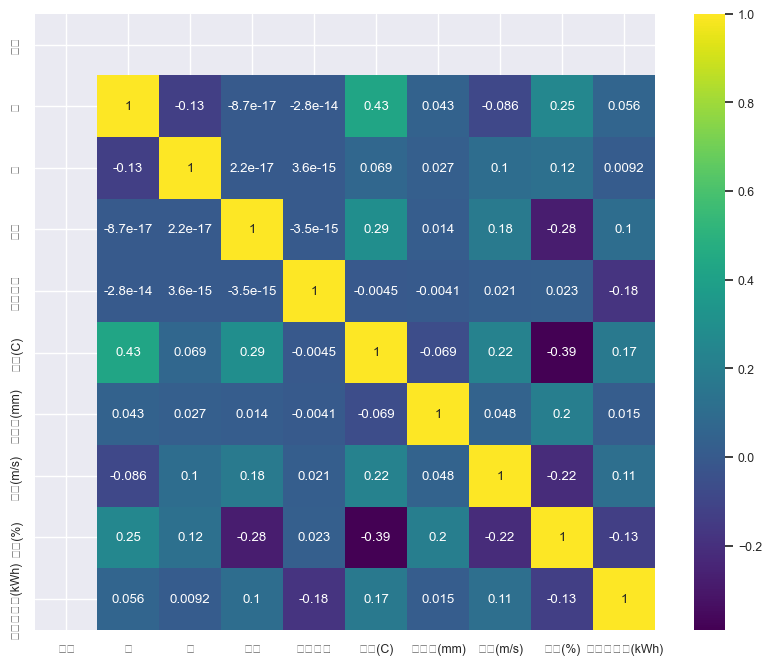

In [120]:
# 상관분석 진행

#상관관계 행렬
df_corr=df.corr()

#히트맵
plt.figure(figsize=(10, 8))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True, cmap="viridis")
plt.show()

In [121]:
corr_order = df_corr.corr()['전력소비량(kWh)'].abs().sort_values(ascending=False)
corr_order

전력소비량(kWh)    1.000000
건물번호          0.494209
습도(%)         0.380940
기온(C)         0.236172
강수량(mm)       0.175739
일             0.144472
시간            0.140611
풍속(m/s)       0.127042
월             0.058818
연도                 NaN
Name: 전력소비량(kWh), dtype: float64

In [122]:
#0.7 이상의 값 없음

In [123]:
df.to_csv('../power/train_df.csv', index=False)

In [124]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

In [125]:
# 정규화하기
# MinMaxScaler 클래스 생성
scaler = MinMaxScaler()

# MinMaxScaler 클래스의 fit_transform() 메서드 사용 데이터 정규화
normalized_data = scaler.fit_transform(df)

# 정규화된 데이터, 데이터 프레임으로 다시 변환
ndf = pd.DataFrame(normalized_data, columns=df.columns)

# 모델링

In [126]:
# 데이터 나누기
X = ndf.iloc[:, :-1]
y = ndf.iloc[:,[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
X_train.head()

,연도,월,일,시간,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%)
82832,0.0,0.5,0.700000,0.347826,0.404040,0.500000,0.000000,0.135338,0.862069
94797,0.0,0.5,0.300000,0.913043,0.464646,0.625926,0.000000,0.060150,0.609195
5369,0.0,0.5,0.766667,0.739130,0.020202,0.659259,0.000000,0.187970,0.735632
107108,0.0,0.5,0.400000,0.869565,0.525253,0.529630,0.015184,0.105263,0.977011
728,0.0,0.5,0.000000,0.347826,0.000000,0.511111,0.000000,0.120301,0.988506


In [128]:
y_train.head()

,전력소비량(kWh)
82832,0.145031
94797,0.192483
5369,0.088939
107108,0.065046
728,0.113576


In [129]:
print(X_train.shape)
print(y_train.shape)

(163200, 9)
(163200, 1)


In [130]:
print(X_test.shape)
print(y_test.shape)

(40800, 9)
(40800, 1)


In [131]:
from tensorflow.keras.layers import Dropout

from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2

In [132]:
tf.random.set_seed(1)

model = Sequential()

model.add(LSTM(256, activation='relu', return_sequences=True,  input_shape=(ndf.shape[1] - 1, 1)))
model.add(LSTM(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(1, activation='linear'))


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 256)            264192    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 477,953
Trainable params: 477,953
Non-trai

In [133]:
# 학습하기
history = model.fit(X_train, y_train, epochs=30, batch_size=35, validation_split=0.2, verbose=1)

Epoch 1/30
3731/3731 [==============================] - 89s 23ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 2/30
3731/3731 [==============================] - 97s 26ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 3/30
3731/3731 [==============================] - 99s 26ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 4/30
3731/3731 [==============================] - 98s 26ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 5/30
3731/3731 [==============================] - 96s 26ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 6/30
3731/3731 [==============================] - 99s 26ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 7/30
3731/3731 [==============================] - 100s 27ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 8/30
3731/3731 [==============================] - 101s 27ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 9/30
3731/3731 [==============================] - 103s 27ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 10/30
3731/3731 [==============================] - 98s 

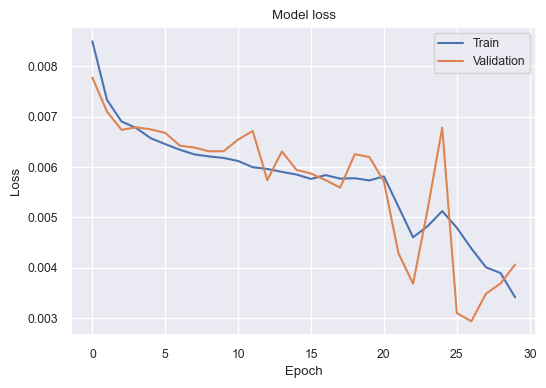

In [134]:
# 시각화 해서 보기
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [135]:
# 예측하기
pred = model.predict(X_test)
print(y_test.shape, pred.shape)

1275/1275 [==============================] - 6s 5ms/step
(40800, 1) (40800, 1)


In [136]:
# 실제값과 예측값 확인하기
predictions = np.array(pred)

In [137]:
# RMSE를 계산(낮을 수록 정확함)
rmse = mean_squared_error(y_test, predictions)
print('rmse :',rmse)

# R^2을 계산(R^2가 1에 가까울수록 모델이 데이터를 잘 설명)
r2 = r2_score(y_test, predictions)
print('r2 :',r2)

# MAE를 계산(MAE가 낮을수록 예측값과 실제값이 가까워짐)
mae = mean_absolute_error(y_test, predictions)
print('mae :',mae)

rmse : 0.003983015096106772
r2 : 0.5633826271712954
mae : 0.03675711962305174


In [138]:
# 테스트용 전처리

In [139]:
test = pd.read_csv('../power/test.csv')

In [140]:
test.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [141]:
test['연도'] = test['일시'].apply(lambda x : int(x[:4]))
test['월'] = test['일시'].apply(lambda x : int(x[4:6]))
test['일'] = test['일시'].apply(lambda x : int(x[6:8]))
test['시간'] = test['일시'].apply(lambda x : int(x[9:11]))

In [142]:
test

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),연도,월,일,시간
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72,2022,8,25,0
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72,2022,8,25,1
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75,2022,8,25,2
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78,2022,8,25,3
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77,2022,8,25,4
...,...,...,...,...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84,2022,8,31,19
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95,2022,8,31,20
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98,2022,8,31,21
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97,2022,8,31,22


In [143]:
test = test.drop(['일시','num_date_time'], axis=1)

In [144]:
test = test[["연도", "월","일", "시간", "건물번호", "기온(C)", "강수량(mm)", "풍속(m/s)", "습도(%)"]]
test.head()

,연도,월,일,시간,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%)
0,2022,8,25,0,1,23.5,0.0,2.2,72
1,2022,8,25,1,1,23.0,0.0,0.9,72
2,2022,8,25,2,1,22.7,0.0,1.5,75
3,2022,8,25,3,1,22.1,0.0,1.3,78
4,2022,8,25,4,1,21.8,0.0,1.0,77


In [145]:
# 정규화하기
# MinMaxScaler 클래스 생성
scaler = MinMaxScaler()

# MinMaxScaler 클래스의 fit_transform() 메서드 사용 데이터 정규화
normalized_data = scaler.fit_transform(test)

# 정규화된 데이터, 데이터 프레임으로 다시 변환
tndf = pd.DataFrame(normalized_data, columns=test.columns)

In [146]:
#예측하기
test_pred = model.predict(tndf)

525/525 [==============================] - 2s 5ms/step


In [147]:
tndf['pred']=test_pred

In [148]:
tndf.head()

,연도,월,일,시간,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),pred
0,0.0,0.0,0.0,0.000000,0.0,0.562189,0.0,0.314286,0.621622,0.059433
1,0.0,0.0,0.0,0.043478,0.0,0.537313,0.0,0.128571,0.621622,0.060042
2,0.0,0.0,0.0,0.086957,0.0,0.522388,0.0,0.214286,0.662162,0.056461
3,0.0,0.0,0.0,0.130435,0.0,0.492537,0.0,0.185714,0.702703,0.056950
4,0.0,0.0,0.0,0.173913,0.0,0.477612,0.0,0.142857,0.689189,0.060450


In [149]:
# 역정규화
min_value = 0.0
max_value = 25488.4
tndf['real_pred'] = tndf['pred'] * (max_value - min_value) + min_value 

In [150]:
#제출
submission = pd.read_csv('../power/sample_submission.csv')
submission['answer'] = tndf['real_pred']
submission.head()

,num_date_time,answer
0,1_20220825 00,1514.864014
1,1_20220825 01,1530.380859
2,1_20220825 02,1439.093384
3,1_20220825 03,1451.566650
4,1_20220825 04,1540.784546


In [151]:
submission.to_csv('../power/power2.csv', index=  False)